![image.png](attachment:image.png)

# Tarefa

Neste exercício vamos usar a base [online shoppers purchase intention](https://archive.ics.uci.edu/ml/datasets/Online+Shoppers+Purchasing+Intention+Dataset) de Sakar, C.O., Polat, S.O., Katircioglu, M. et al. Neural Comput & Applic (2018). [Web Link](https://doi.org/10.1007/s00521-018-3523-0).

A base trata de registros de 12.330 sessões de acesso a páginas, cada sessão sendo de um único usuário em um período de 12 meses, para posteriormente estudarmos a relação entre o design da página e o perfil do cliente - "Será que clientes com comportamento de navegação diferentes possuem propensão a compra diferente?"

Nosso objetivo é tentar agrupar os clientes conforme seu comportamento de navegação entre páginas administrativas, informativas e de produtos.

As variáveis estão descritas abaixo (em tradução livre do link indicado).

Por este motivo, o escopo desta análise estará fechado nas primeiras seis variáveis da tabela, referentes a quantidade e tempo de acesso por tipo de página, atributos que falam mais do comportamento de navegação do cliente que de características da página o da época do ano.

|Variavel                |Descrição          |
|------------------------|:-------------------|
|Administrative          | Quantidade de acessos em páginas administrativas|
|Administrative_Duration | Tempo de acesso em páginas administrativas |
|Informational           | Quantidade de acessos em páginas informativas  |
|Informational_Duration  | Tempo de acesso em páginas informativas  |
|ProductRelated          | Quantidade de acessos em páginas de produtos |
|ProductRelated_Duration | Tempo de acesso em páginas de produtos |
|BounceRates             | *Percentual de visitantes que entram no site e saem sem acionar outros *requests* durante a sessão  |
|ExitRates               | * Soma de vezes que a página é visualizada por último em uma sessão dividido pelo total de visualizações |
|PageValues              | * Representa o valor médio de uma página da Web que um usuário visitou antes de concluir uma transação de comércio eletrônico |
|SpecialDay              | Indica a proximidade a uma data festiva (dia das mães etc) |
|Month                   | Mês  |
|OperatingSystems        | Sistema operacional do visitante |
|Browser                 | Browser do visitante |
|Region                  | Região |
|TrafficType             | Tipo de tráfego                  |
|VisitorType             | Tipo de visitante: novo ou recorrente |
|Weekend                 | Indica final de semana |
|Revenue                 | Indica se houve compra ou não |

\* variávels calculadas pelo google analytics

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

from sklearn.metrics import silhouette_score
from tqdm.notebook import tqdm

In [ ]:
df = pd.read_csv('/content/online_shoppers_intention.csv')

In [ ]:
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [ ]:
df.Revenue.value_counts(dropna=False)

,count
Revenue,
False,10422
True,1908


## Análise descritiva

Faça uma análise descritiva das variáveis do escopo.

- Verifique a distribuição dessas variáveis
- Veja se há valores *missing* e caso haja, decida o que fazer
- Faça mais algum tratamento nas variáveis caso ache pertinente

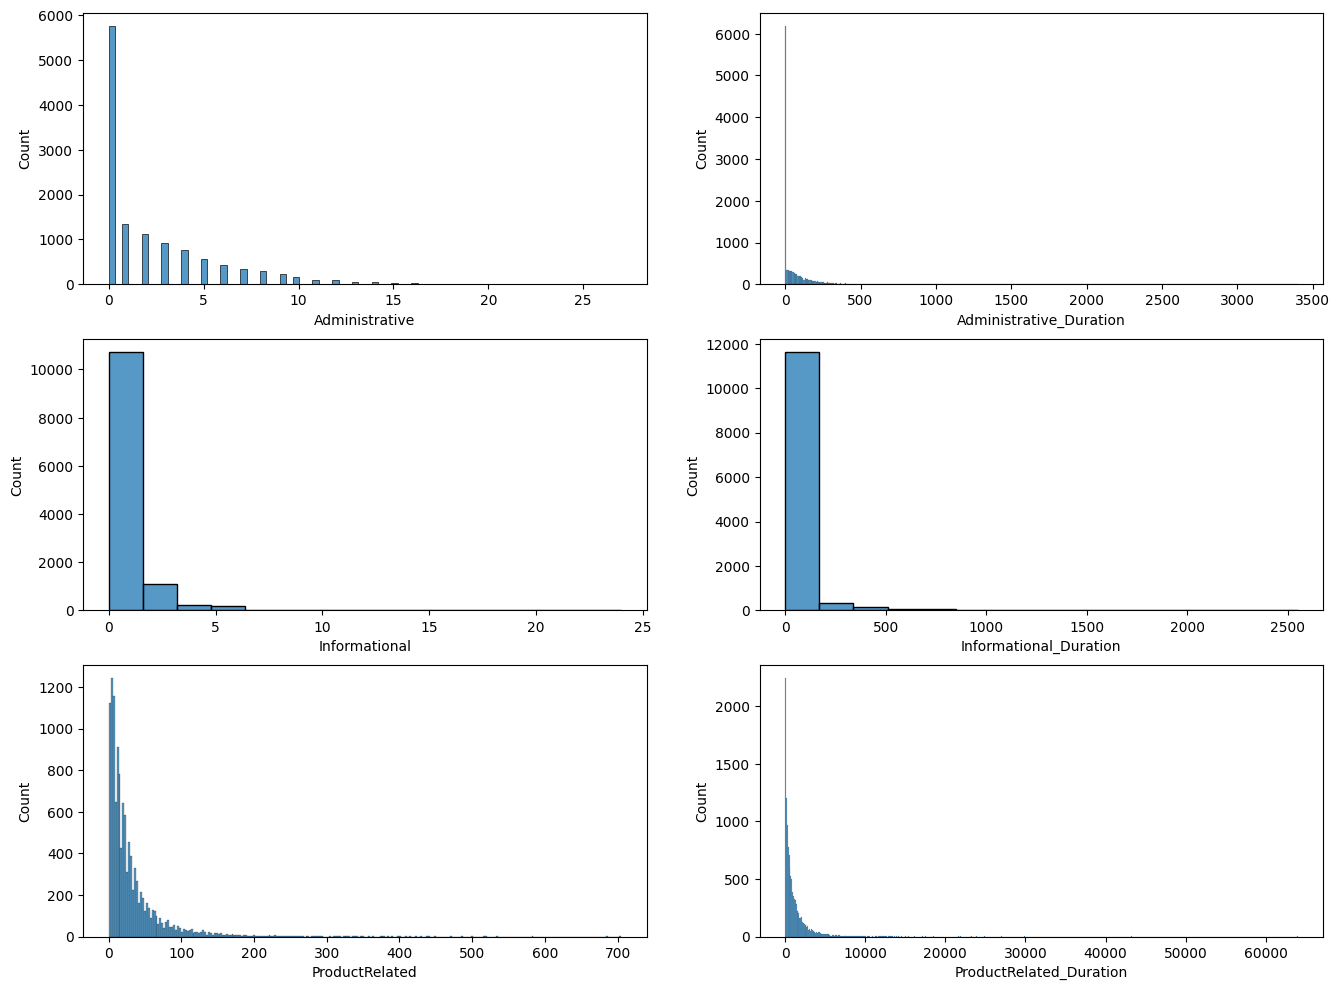

In [ ]:
#Para cada uma das primeiras 6 colunas do DataFrame, ele gera um histograma.
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 12))
variaveis = df.columns[:6]
for i, var in enumerate(variaveis):
    sns.histplot(ax=axes[i//2][i%2], x=df[var])

In [ ]:
# exibe a contagem de valores nulos e não nulos,itera pelos resultados de contagem e mostra a contage de False
for var in variaveis:
    print(f"{var}")
    count_na = df[var].isna().value_counts()
    for index, value in count_na.items():
        print(f"{index}: {value}")
    print()

Administrative
False: 12330

Administrative_Duration
False: 12330

Informational
False: 12330

Informational_Duration
False: 12330

ProductRelated
False: 12330

ProductRelated_Duration
False: 12330



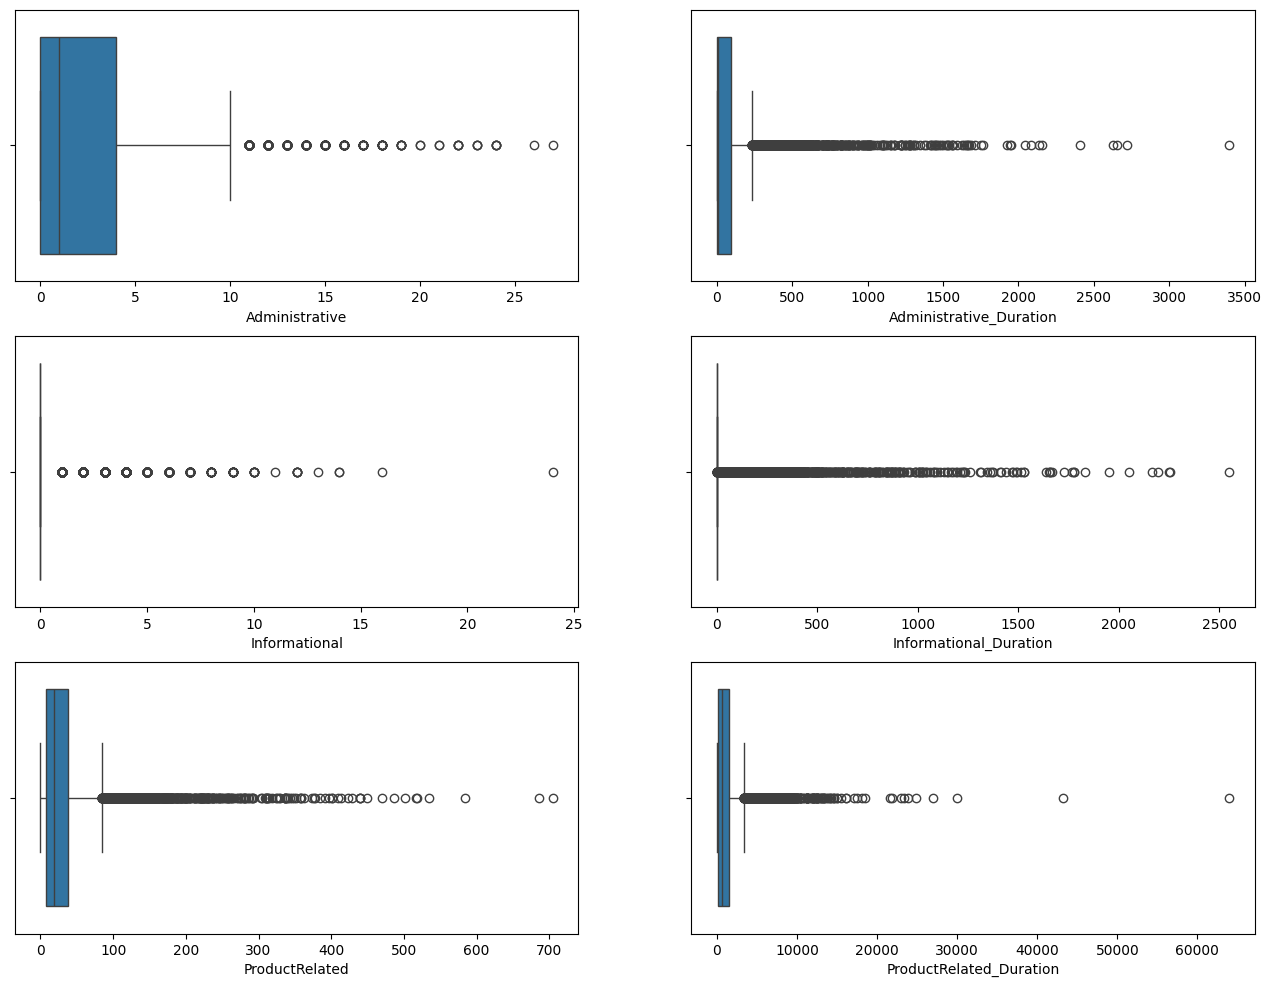

In [ ]:
#Para cada uma das primeiras 6 colunas do DataFrame, ele gera um boxplot.
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 12))
variaveis = df.columns[:6]
for i, var in enumerate(variaveis):
    sns.boxplot(ax=axes[i//2][i%2], x=df[var])

In [ ]:
#Calcula o Q1, Q3, e o IQR para cada variável, define o limite superior para os outliers e conta quantos desses valores existem.
for var in variaveis:
    q1 = df[var].quantile(q=0.25)
    q3 = df[var].quantile(q=0.75)
    iqr = q3 - q1
    outliers_cut = q3 + (1.5 * iqr)
    num_outliers = df.query(f"{var} > @outliers_cut").shape[0]

    print(f"{var}")
    print(f"Ponto de corte para outliers: {outliers_cut}")
    print(f"3º quartil: {q3}")
    print(f"Número de outliers: {num_outliers}")
    print()

Administrative
Ponto de corte para outliers: 10.0
3º quartil: 4.0
Número de outliers: 404

Administrative_Duration
Ponto de corte para outliers: 233.14062499999997
3º quartil: 93.25625
Número de outliers: 1172

Informational
Ponto de corte para outliers: 0.0
3º quartil: 0.0
Número de outliers: 2631

Informational_Duration
Ponto de corte para outliers: 0.0
3º quartil: 0.0
Número de outliers: 2405

ProductRelated
Ponto de corte para outliers: 84.5
3º quartil: 38.0
Número de outliers: 987

ProductRelated_Duration
Ponto de corte para outliers: 3384.1867837500004
3º quartil: 1464.1572135000001
Número de outliers: 961



## Número de grupos

Utilize as técnicas vistas em aula que te ajudem a decidir pelo número de grupos a ser utilizados.

In [ ]:
#dividir em conjunto de treino e conjunto de teste
X = df[variaveis]
X_train, X_test = train_test_split(X, test_size=0.3)
X_train.shape, X_test.shape

((8631, 6), (3699, 6))

In [ ]:
#padronizando o conjunto de treino X_train e criando um novo DataFrame X_pad com os dados normalizados
X_pad = pd.DataFrame(StandardScaler().fit_transform(X_train), columns = X_train.columns)
X_pad

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration
0,-0.699255,-0.458934,-0.399380,-0.245389,-0.495569,-0.490014
1,-0.699255,-0.458934,1.961610,0.333358,-0.518061,-0.555124
2,-0.699255,-0.458934,-0.399380,-0.245389,-0.675505,-0.621549
3,-0.699255,-0.458934,-0.399380,-0.245389,-0.180681,-0.430037
4,-0.102413,-0.250594,0.387617,-0.119117,-0.158189,-0.404207
...,...,...,...,...,...,...
8626,-0.400834,0.002793,-0.399380,-0.245389,0.674014,0.022948
8627,0.196008,-0.143608,-0.399380,-0.245389,0.651522,0.247286
8628,-0.699255,-0.458934,-0.399380,-0.245389,-0.608029,-0.468069
8629,1.688114,0.461000,-0.399380,-0.245389,-0.315633,-0.418442


In [ ]:
#determinar o número ideal de clusters para uma análise de agrupamento
SSD = []
K = range(1, 15)
for k in tqdm(K):
    km = KMeans(n_init=10, n_clusters=k)
    km = km.fit(X_pad)
    SSD.append(km.inertia_)

  0%|          | 0/14 [00:00<?, ?it/s]

In [ ]:
SSD

[51785.99999999967,
 35770.90217796355,
 30215.36547329249,
 26045.365564773598,
 23258.33775666718,
 20575.62492979674,
 18627.955323886952,
 16869.457507252504,
 15678.635898915772,
 14634.208898384211,
 13715.637904154371,
 13096.207124779185,
 12466.169690314975,
 11983.434824127517]

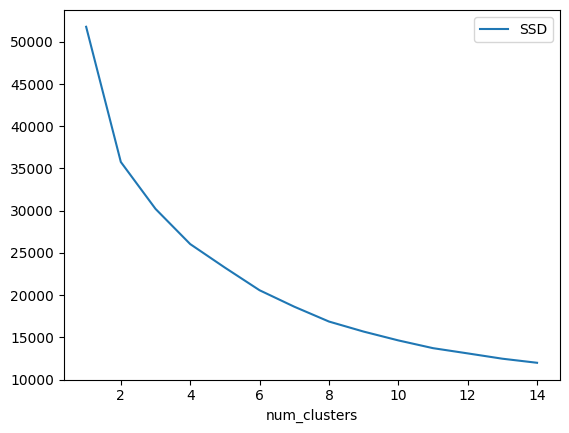

In [ ]:
#cria um DataFrame elbow_df contendo o número de clusters e a soma dos quadrados das distâncias (SSD) para cada número de clusters
elbow_df = pd.DataFrame({'num_clusters': list(range(1, len(SSD)+1)), 'SSD': SSD})
elbow_df.plot(x = 'num_clusters', y = 'SSD');

In [ ]:
#Cria e ajusta um modelo K-means com um único cluster e 10 inicializações do algoritmo para garantir que o melhor resultado seja encontrado
km = KMeans(n_init=10, n_clusters=1)
km = km.fit(X_pad)
km.labels_

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [ ]:
#avalia agrupamento usando a métrica de coeficiente de silhueta para diferentes números de clusters
silhuetas = []
K = range(2, 15)
for k in tqdm(K):
    km = KMeans(n_init=10, n_clusters=k)
    km = km.fit(X_pad)
    silhuetas.append(silhouette_score(X_pad, km.labels_))


  0%|          | 0/13 [00:00<?, ?it/s]

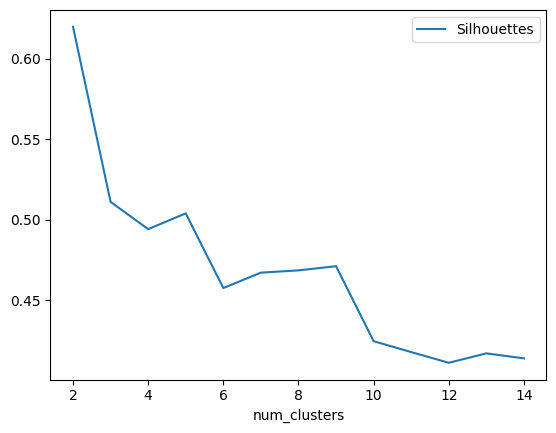

In [ ]:
#Cria um DataFrame silhouettes_df para armazenar o número de clusters e os valores do coeficiente de silhueta correspondentes.
silhouettes_df = pd.DataFrame({'num_clusters': list(K), 'Silhouettes': silhuetas})
silhouettes_df.plot(x = 'num_clusters', y = 'Silhouettes');


In [ ]:
#agrupa os dados usando o algoritmo K-means com 2 clusters
km = KMeans(n_init=10, n_clusters=2).fit(X_pad)
model = X_pad.copy()
model['y1'] = df["Revenue"]
model['y2'] = df["BounceRates"]
model["2_grupos"] = km.labels_
model["2_grupos"] = model["2_grupos"].astype("category")
model

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,y1,y2,2_grupos
0,-0.699255,-0.458934,-0.399380,-0.245389,-0.495569,-0.490014,False,0.200000,0
1,-0.699255,-0.458934,1.961610,0.333358,-0.518061,-0.555124,False,0.000000,0
2,-0.699255,-0.458934,-0.399380,-0.245389,-0.675505,-0.621549,False,0.200000,0
3,-0.699255,-0.458934,-0.399380,-0.245389,-0.180681,-0.430037,False,0.050000,0
4,-0.102413,-0.250594,0.387617,-0.119117,-0.158189,-0.404207,False,0.020000,0
...,...,...,...,...,...,...,...,...,...
8626,-0.400834,0.002793,-0.399380,-0.245389,0.674014,0.022948,False,0.000000,0
8627,0.196008,-0.143608,-0.399380,-0.245389,0.651522,0.247286,True,0.018182,0
8628,-0.699255,-0.458934,-0.399380,-0.245389,-0.608029,-0.468069,False,0.000000,0
8629,1.688114,0.461000,-0.399380,-0.245389,-0.315633,-0.418442,True,0.000000,0


In [ ]:
#agrupa os dados usando o algoritmo K-means com 3 clusters
km = KMeans(n_init=10, n_clusters=3).fit(X_pad)
model["3_grupos"] = km.labels_
model["3_grupos"] = model["3_grupos"].astype("category")
model

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,y1,y2,2_grupos,3_grupos
0,-0.699255,-0.458934,-0.399380,-0.245389,-0.495569,-0.490014,False,0.200000,0,0
1,-0.699255,-0.458934,1.961610,0.333358,-0.518061,-0.555124,False,0.000000,0,0
2,-0.699255,-0.458934,-0.399380,-0.245389,-0.675505,-0.621549,False,0.200000,0,0
3,-0.699255,-0.458934,-0.399380,-0.245389,-0.180681,-0.430037,False,0.050000,0,0
4,-0.102413,-0.250594,0.387617,-0.119117,-0.158189,-0.404207,False,0.020000,0,0
...,...,...,...,...,...,...,...,...,...,...
8626,-0.400834,0.002793,-0.399380,-0.245389,0.674014,0.022948,False,0.000000,0,0
8627,0.196008,-0.143608,-0.399380,-0.245389,0.651522,0.247286,True,0.018182,0,0
8628,-0.699255,-0.458934,-0.399380,-0.245389,-0.608029,-0.468069,False,0.000000,0,0
8629,1.688114,0.461000,-0.399380,-0.245389,-0.315633,-0.418442,True,0.000000,0,1


In [ ]:
#agrupa os dados usando o algoritmo K-means com 4 clusters
km = KMeans(n_init=10, n_clusters=4).fit(X_pad)
model["4_grupos"] = km.labels_
model["4_grupos"] = model["4_grupos"].astype("category")
model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8631 entries, 0 to 8630
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   Administrative           8631 non-null   float64 
 1   Administrative_Duration  8631 non-null   float64 
 2   Informational            8631 non-null   float64 
 3   Informational_Duration   8631 non-null   float64 
 4   ProductRelated           8631 non-null   float64 
 5   ProductRelated_Duration  8631 non-null   float64 
 6   y1                       8631 non-null   bool    
 7   y2                       8631 non-null   float64 
 8   2_grupos                 8631 non-null   category
 9   3_grupos                 8631 non-null   category
 10  4_grupos                 8631 non-null   category
dtypes: bool(1), category(3), float64(7)
memory usage: 506.3 KB


## Avaliação dos grupos

Faça uma análise descritiva para pelo menos duas soluções de agrupamentos (duas quantidades diferentes de grupos) sugeridas no item anterior, utilizando as variáveis que estão no escopo do agrupamento.
- Com base nesta análise e nas análises anteriores, decida pelo agrupamento final.
- Se puder, sugira nomes para os grupos.

**Resposta:** Foi decidido pela classificação em 3 grupos, visto que é um valor indicado pelas métricas anteriores e pelas análises descritiva, não se observou um ganho de diferenciação quando se aumenta para 4 grupos

In [ ]:
model[variaveis].shape

(8631, 6)

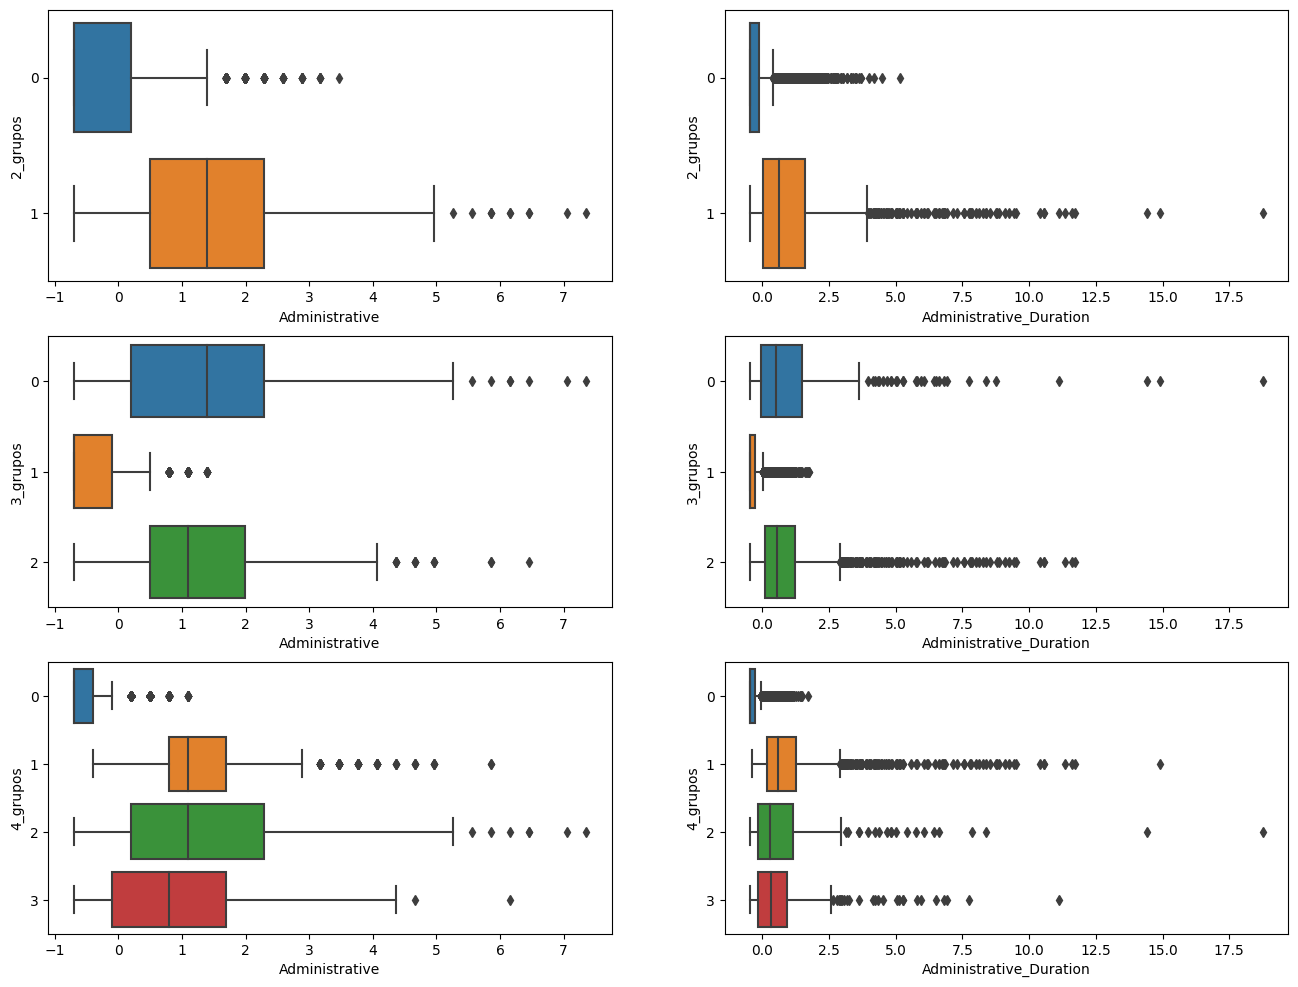

In [ ]:
#cria gráficos de boxplot comparando as variáveis.
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 12))
grupos = ["2_grupos", "3_grupos", "4_grupos"]
for i in range(2 * len(grupos)):
    sns.boxplot(data=model, ax=axes[i//2][i%2], y=grupos[i//2], x=variaveis[i%2])

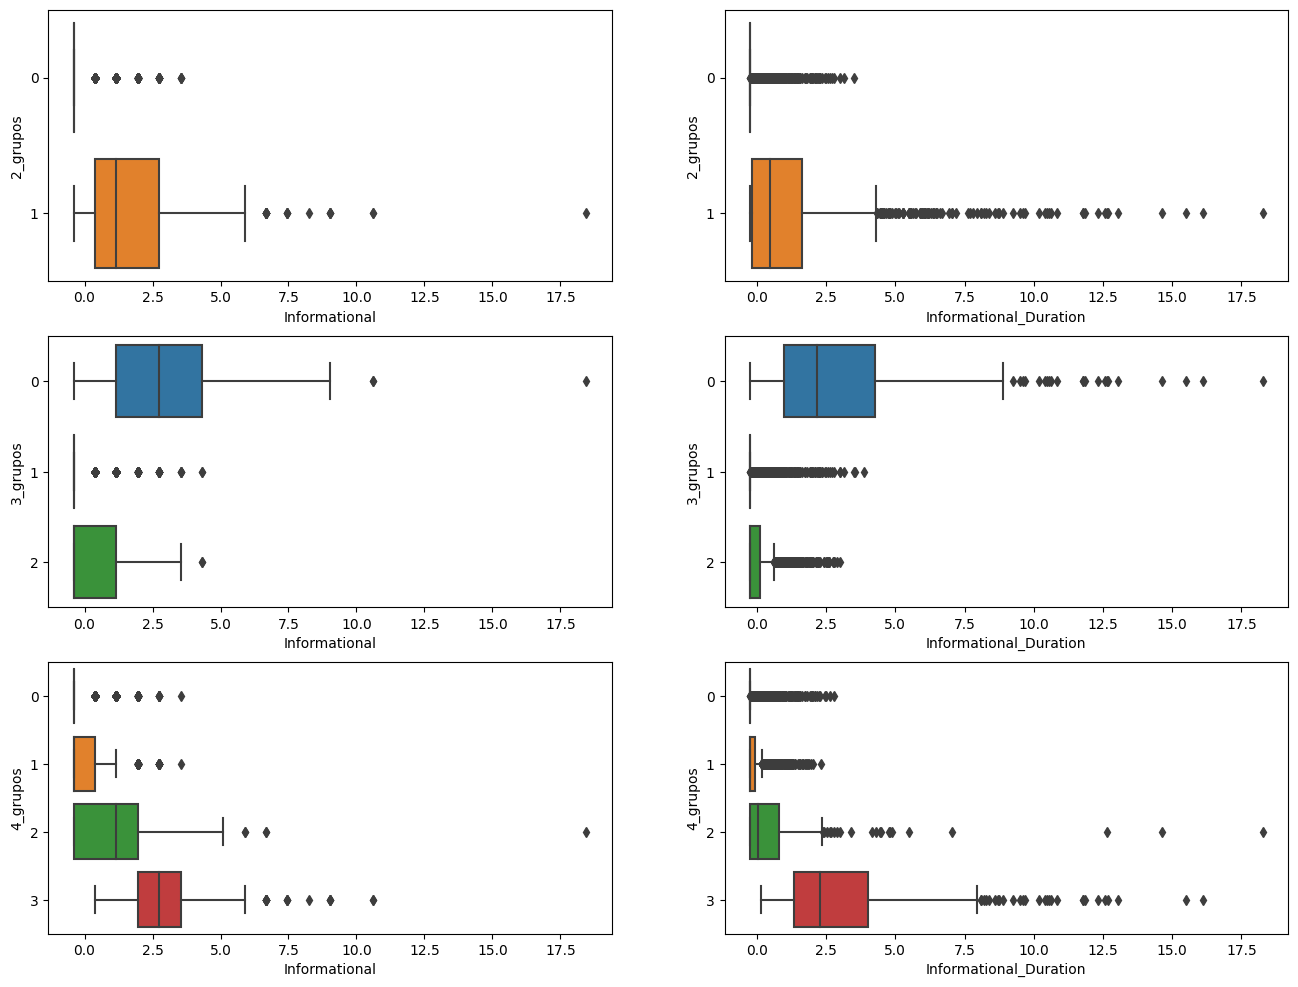

In [ ]:
#cria gráficos de boxplot comparando as variáveis.
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 12))
grupos = ["2_grupos", "3_grupos", "4_grupos"]
for i in range(2 * len(grupos)):
    sns.boxplot(data=model, ax=axes[i//2][i%2], y=grupos[i//2], x=variaveis[(i%2)+2])

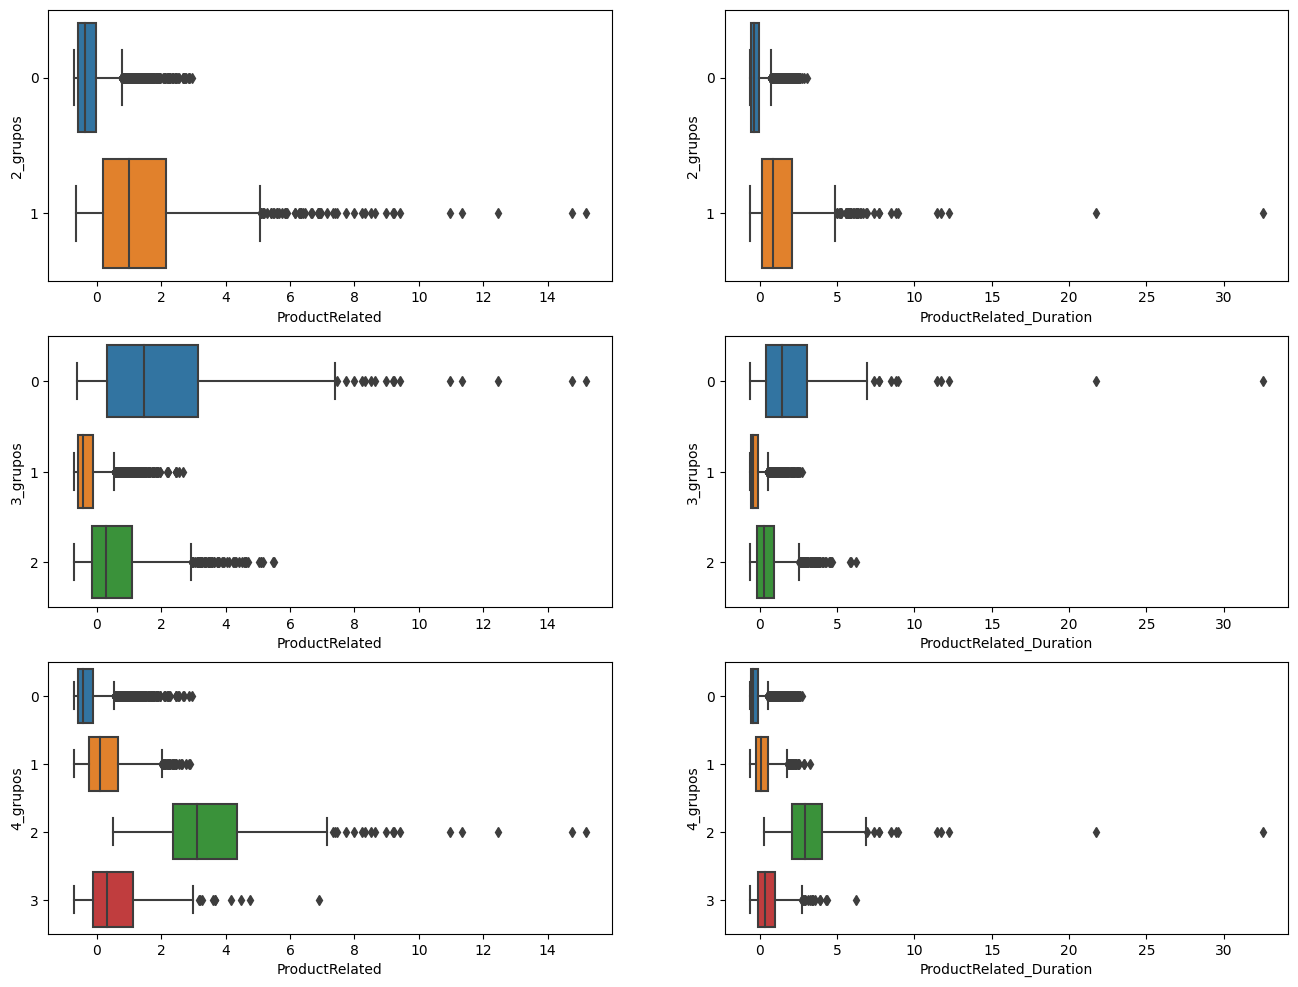

In [ ]:
#cria gráficos de boxplot comparando as variáveis.
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 12))
grupos = ["2_grupos", "3_grupos", "4_grupos"]
for i in range(2 * len(grupos)):
    sns.boxplot(data=model, ax=axes[i//2][i%2], y=grupos[i//2], x=variaveis[(i%2)+4])

## Avaliação de resultados

Avalie os grupos obtidos com relação às variáveis fora do escopo da análise (minimamente *bounce rate* e *revenue*).
- Qual grupo possui clientes mais propensos à compra?

**Resposta:**

####  O gráfico de boxplot indica que o Grupo 2 tem uma mediana de bounce rate mais baixa, o que sugere que esses clientes interagem mais com o conteúdo, saindo menos rapidamente das páginas (o que poderia indicar maior engajamento).Este grupo tem a menor quantidade de clientes, mas a proporção de compradores (valor True em y1) é a maior entre os três grupos.

In [ ]:
#cria uma tabela cruzada para analisar duas duas variaveis categoricas
pd.crosstab(model['y1'], model['3_grupos'])

3_grupos,0,1,2
y1,,,
False,5687,1477,304
True,863,257,43


<ipython-input-45-a59964e17e31>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ax = model.groupby(['3_grupos', 'y1'])['y1'].count().unstack().plot.bar()


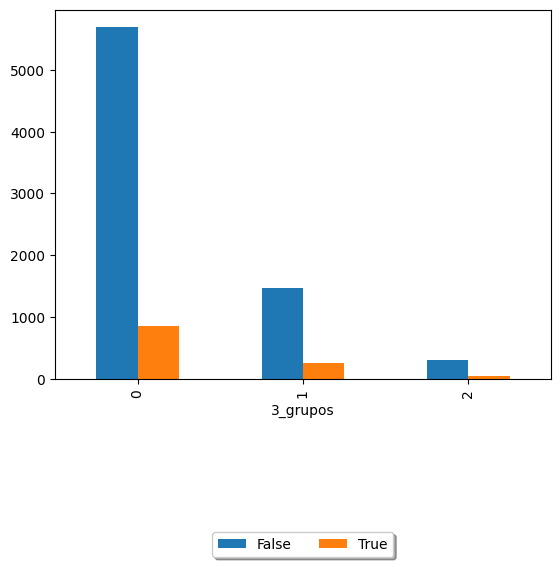

In [ ]:
#gráfico de barras para visualizar a distribuição da variável y1(Revenue) em relação aos clusters definidos na coluna 3_grupos
ax = model.groupby(['3_grupos', 'y1'])['y1'].count().unstack().plot.bar()

ax.legend(loc='lower center', bbox_to_anchor=(0.5, -.5),
          ncol=3, fancybox=True, shadow=True);

<Axes: xlabel='y2', ylabel='3_grupos'>

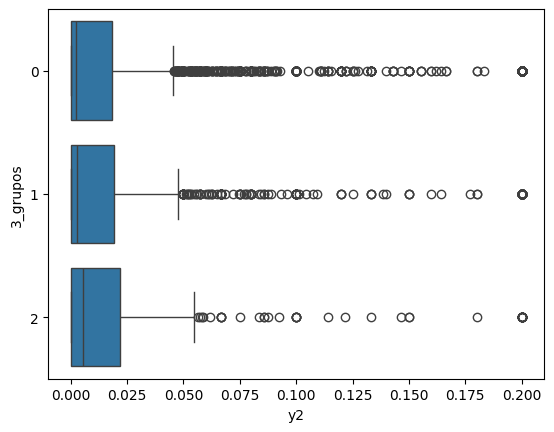

In [ ]:
#gráfico de boxplot visualizar a distribuição da variável y2 (bounce rate) em relação aos grupos definidos pela coluna 3_grupos
sns.boxplot(data=model, y="3_grupos", x="y2")